# Analyse micrographs of single trace experiment

Process .tif micrographs of single trace experiment and extract parameters of two intersecting circles that encapsulate the bead cross section

## Demonstraion

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from pathlib import Path as path
import pandas as pd
from tqdm.auto import tqdm

def find_bead_parameters(file_name, voxel_to_micro, kernel, debug):
    # read an image, blur it
    rgb_image = plt.imread(file_name)
    kernel_size = 23
    rgb_image = cv.medianBlur(rgb_image, kernel_size)

    # segment the image using dominant color in each pixel then smooth the output via a blurring filter
    flatten_image = rgb_image.reshape(-1, 3)
    flatten_color_segmented_image = np.zeros_like(flatten_image)
    idx = np.argmax(flatten_image, axis=1)
    flatten_color_segmented_image[idx == 0] = [255, 0, 0]
    flatten_color_segmented_image[idx == 1] = [0, 255, 0]
    flatten_color_segmented_image[idx == 2] = [0, 0, 255]
    color_segmented_image = flatten_color_segmented_image.reshape(rgb_image.shape)
    kernel_size = 17
    color_segmented_image = cv.medianBlur(color_segmented_image, kernel_size)

    # map segmented image into a binary one
    binary_image = cv.cvtColor(color_segmented_image, cv.COLOR_RGB2GRAY)
    rng = (binary_image > 15) & (binary_image < 30)
    binary_image[rng] = 1
    binary_image[~rng] = 0

    # extract region of interest using morphological operations
    # Idea: number of iterations can be decided automatically if we keep increasing iterations till there's only one contour,
    # check: https://www.geeksforgeeks.org/find-and-draw-contours-using-opencv-python/

    # more iterations -> more blue area
    opening = cv.bitwise_not(cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel, iterations=50))

    # remove small yellow noise
    open_temp = cv.morphologyEx(binary_image, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10)), iterations=3)
    # more iterations -> more yellow area
    closing = cv.morphologyEx(open_temp, cv.MORPH_CLOSE, kernel, iterations=50)

    # intersect both images and smooth the resulting edges
    bead = cv.bitwise_and(opening, closing)
    bead = cv.morphologyEx(bead, cv.MORPH_OPEN, kernel, iterations=23)

    if debug:
        fig, ax = plt.subplots(1, 3, figsize=[16, 4])
        ax[1].set_title('blurred input image')
        ax[0].imshow(rgb_image)

        ax[1].set_title('dominant color segmentation')
        ax[1].imshow(color_segmented_image)

        ax[2].set_title('binary segmentation / mask')
        ax[2].imshow(binary_image, cmap="gray")

        fig, ax = plt.subplots(1, 3, figsize=[16, 4])
        ax[0].imshow(opening)
        ax[1].imshow(closing)
        ax[2].imshow(bead)

    # surround region of interest by an intersection of two circles
    width = np.max(np.sum(bead, axis=1))
    w = width / 2
    cx = np.argmax(np.sum(bead, axis=0) > 0) + int(w)
    cy = np.argmax(np.sum(bead, axis=1))

    h_top = np.max(np.sum(bead[:cy, :], axis=0))
    h_bottom = np.max(np.sum(bead[cy:, :], axis=0))

    if h_top * h_bottom == 0:
        print(f'***error in {file_name}, {cx=}, {cy=}, {h_top=}, {h_bottom=}, {width=}')
        return

    r_top = int((h_top ** 2 + w ** 2) / (2 * h_top))
    r_bottom = int((h_bottom ** 2 + w ** 2) / (2 * h_bottom))

    img = np.copy(rgb_image)
    angle_top = np.rad2deg(np.arctan(w / (r_top - h_top)))
    angle_bottom = np.rad2deg(np.arctan(w / (r_bottom - h_bottom)))

    a1 = np.deg2rad(angle_top) * 2
    a2 = np.deg2rad(angle_bottom) * 2
    area_top = 0.5 * r_top ** 2 * (a1 - np.sin(a1))
    area_bottom = 0.5 * r_bottom ** 2 * (a2 - np.sin(a2))

    height = h_top + h_bottom
    aspect_ratio = height / width
    vol_frac = area_top / (area_top + area_bottom)

    # cv.circle(img, (cx, cy), 300, (255, 0, 0), 20)
    cv.ellipse(img, (cx, cy + r_top - int(h_top)), (r_top, r_top), 180, 90 - angle_top, 90 + angle_top, (255, 0, 0), 20)
    cv.ellipse(img, (cx, cy - r_bottom + int(h_bottom)), (r_bottom, r_bottom), 0, 90 - angle_bottom, 90 + angle_bottom,
               (255, 0, 0), 20)

    if debug:
        fig, ax = plt.subplots(1, 3, figsize=[16, 4])
        ax[0].set_axis_off()
        ax[2].set_axis_off()
        ax[1].text(0, 0, file_name)
        ax[1].set_axis_off()
        ax[1].imshow(img)

    return {'img': img, 'vol_frac': vol_frac, 'angle_top': angle_top, 'angle_bottom': angle_bottom,
            'width': width * voxel_to_micro,
            'height': height * voxel_to_micro,
            'h_top': h_top * voxel_to_micro, 'h_bottom': h_bottom * voxel_to_micro, 'aspect_ratio': aspect_ratio, 'area_top': area_top, 'area_bottom': area_bottom}


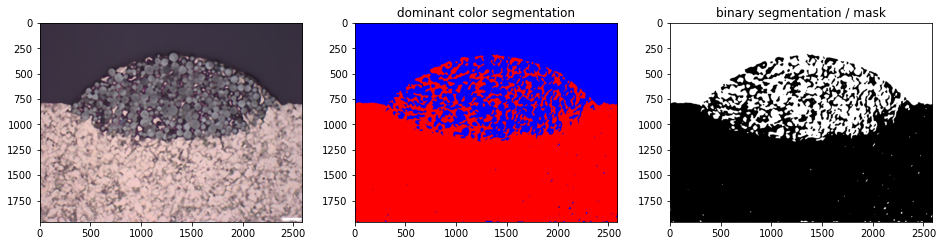

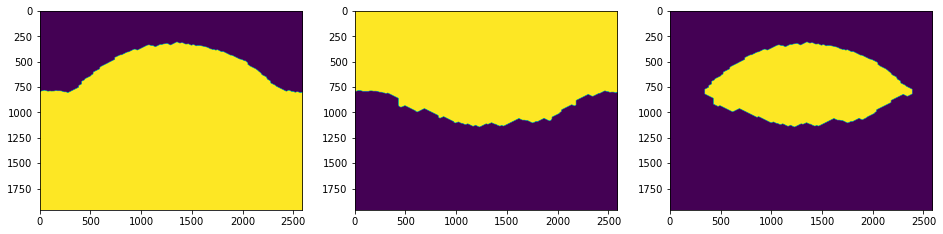

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
find_bead_parameters(file_name='input/C37-3.tif', voxel_to_micro=1, kernel=kernel, debug=True);


In [ ]:
# DEL TEMP save png

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
file_name='input/C37-3.tif'
voxel_to_micro=1
debug=True

# read an image, blur it
rgb_image = plt.imread(file_name)
kernel_size = 23
rgb_image = cv.medianBlur(rgb_image, kernel_size)

# segment the image using dominant color in each pixel then smooth the output via a blurring filter
flatten_image = rgb_image.reshape(-1, 3)
flatten_color_segmented_image = np.zeros_like(flatten_image)
idx = np.argmax(flatten_image, axis=1)
flatten_color_segmented_image[idx == 0] = [255, 0, 0]
flatten_color_segmented_image[idx == 1] = [0, 255, 0]
flatten_color_segmented_image[idx == 2] = [0, 0, 255]
color_segmented_image = flatten_color_segmented_image.reshape(rgb_image.shape)
kernel_size = 17
color_segmented_image = cv.medianBlur(color_segmented_image, kernel_size)

# map segmented image into a binary one
binary_image = cv.cvtColor(color_segmented_image, cv.COLOR_RGB2GRAY)
rng = (binary_image > 15) & (binary_image < 30)
binary_image[rng] = 1
binary_image[~rng] = 0

# extract region of interest using morphological operations
# Idea: number of iterations can be decided automatically if we keep increasing iterations till there's only one contour,
# check: https://www.geeksforgeeks.org/find-and-draw-contours-using-opencv-python/

# more iterations -> more blue area
opening = cv.bitwise_not(cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel, iterations=50))

# remove small yellow noise
open_temp = cv.morphologyEx(binary_image, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10)), iterations=3)
# more iterations -> more yellow area
closing = cv.morphologyEx(open_temp, cv.MORPH_CLOSE, kernel, iterations=50)

# intersect both images and smooth the resulting edges
bead = cv.bitwise_and(opening, closing)
bead = cv.morphologyEx(bead, cv.MORPH_OPEN, kernel, iterations=23)

if debug:
    fig, ax = plt.subplots(1, 3, figsize=[16, 4])
#     ax[1].set_title('blurred input image')
    ax[0].imshow(rgb_image)

#     ax[1].set_title('dominant color segmentation')
    ax[1].imshow(color_segmented_image)

#     ax[2].set_title('binary segmentation / mask')
    ax[2].imshow(binary_image, cmap="gray")
    ax[0].set_axis_off()
    ax[2].set_axis_off()
    ax[1].set_axis_off()
    fig.tight_layout(pad=0.1)
    fig.savefig('1.png',dpi=300)
    
    fig, ax = plt.subplots(1, 3, figsize=[16, 4])
    ax[0].imshow(opening)
    ax[1].imshow(closing)
    ax[2].imshow(bead)
    
    ax[0].set_axis_off()
    ax[2].set_axis_off()
    ax[1].set_axis_off()
    
    fig.tight_layout(pad=0.1)
    fig.savefig('2.png',dpi=300)

# surround region of interest by an intersection of two circles
width = np.max(np.sum(bead, axis=1))
w = width / 2
cx = np.argmax(np.sum(bead, axis=0) > 0) + int(w)
cy = np.argmax(np.sum(bead, axis=1))

h_top = np.max(np.sum(bead[:cy, :], axis=0))
h_bottom = np.max(np.sum(bead[cy:, :], axis=0))

r_top = int((h_top ** 2 + w ** 2) / (2 * h_top))
r_bottom = int((h_bottom ** 2 + w ** 2) / (2 * h_bottom))

img = np.copy(rgb_image)
angle_top = np.rad2deg(np.arctan(w / (r_top - h_top)))
angle_bottom = np.rad2deg(np.arctan(w / (r_bottom - h_bottom)))

a1 = np.deg2rad(angle_top) * 2
a2 = np.deg2rad(angle_bottom) * 2
area_top = 0.5 * r_top ** 2 * (a1 - np.sin(a1))
area_bottom = 0.5 * r_bottom ** 2 * (a2 - np.sin(a2))

height = h_top + h_bottom
aspect_ratio = height / width
vol_frac = area_top / (area_top + area_bottom)

# cv.circle(img, (cx, cy), 300, (255, 0, 0), 20)
cv.ellipse(img, (cx, cy + r_top - int(h_top)), (r_top, r_top), 180, 90 - angle_top, 90 + angle_top, (255, 0, 0), 20)
cv.ellipse(img, (cx, cy - r_bottom + int(h_bottom)), (r_bottom, r_bottom), 0, 90 - angle_bottom, 90 + angle_bottom,
           (255, 0, 0), 20)

if debug:
    fig, ax = plt.subplots(1, 3, figsize=[16, 4])
    ax[0].set_axis_off()
    ax[2].set_axis_off()
    ax[1].set_axis_off()
    ax[1].imshow(img)

    fig.tight_layout(pad=0.1)
    fig.savefig('3.png',dpi=300)

## Process all images

In [ ]:
save_all_fig = False
voxel_to_micro = 185 / 200

# read excel file that contains processing parameters
dataframe = pd.read_excel('input/auswertung.xlsx', sheet_name=0, header=0)

# read all files with .tif extension
files = list(path('input').glob('*.tif'))
files.sort()
number_of_files = len(files)
if save_all_fig:
    n_columns = 3
    n_rows = np.maximum(2, number_of_files // 3)
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(4 * n_columns, 4 * n_rows))

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
for file_idx, file_name in enumerate(tqdm(files)):
    # print(f'processing file {file_idx + 1} out of {number_of_files}')
    output = find_bead_parameters(file_name=file_name, voxel_to_micro=voxel_to_micro, kernel=kernel, debug=False)

    if save_all_fig:
        ax[file_idx // 3, file_idx % 3].text(0, 0, file_name.name)
        ax[file_idx // 3, file_idx % 3].set_axis_off()
        ax[file_idx // 3, file_idx % 3].imshow(output['img'])

    # write obtained measurements into excel
    row_id = dataframe['file_name'] == file_name.name
    row = dataframe.loc[row_id]
    # row['Temperatur °C'].item()

    dataframe.loc[row_id, ['angle_top', 'angle_bottom', 'width', 'height', 'h_top', 'h_bottom', 'aspect_ratio','vol_frac','area_top','area_bottom']] = [
        output['angle_top'], output['angle_bottom'], output['width'], output['height'], output['h_top'], output['h_bottom'],
        output['aspect_ratio'],output['vol_frac'],output['area_top'],output['area_bottom']]

if save_all_fig:
    fig.tight_layout()
    plt.savefig(path('output') / 'processed_micrographs.pdf', bbox_inches='tight', pad_inches=0.01, dpi=200)
    
dataframe.to_excel('output/statistics.xlsx', index=False)

<img src="attachment/processed_images.png" width="500"/>

- Model parameters are extracted automatically
- Statistics may be extracted

In [ ]:
dataframe = pd.read_excel('output/statistics.xlsx', sheet_name=0, header=0)

col1 = ['angle_top', 'h_top', 'aspect_ratio']
col2 = ['angle_bottom', 'width', 'height', 'h_bottom']
pd.set_option('display.max_columns', None)
# dataframe.loc[17:,col].plot()
dataframe.loc[17:, col1 + col2].describe()

In [ ]:
data = dataframe.loc[87:, col2]
centered_data = data - data.mean()
standarized_data = centered_data / np.abs(centered_data).max()
standarized_data.plot()
plt.grid()
plt.title('Standarized data')
plt.xlabel('sample id [-]');

In [ ]:
pd.plotting.scatter_matrix(dataframe.loc[17:, col1 + col2], figsize=(8, 8));
# plt.matshow(dataframe.corr())


In [ ]:
angle_bottom = np.asarray(dataframe.loc[:, 'angle_bottom'].dropna()).reshape(-1, 3)
mean_angle = np.mean(angle_bottom, axis=1)
angles = mean_angle - np.mean(mean_angle)
plt.scatter(range(len(angles)), angles)
plt.grid()
plt.title('Bottom angles shifted to have zero mean')
plt.ylabel('angle [degree]')
plt.xlabel('Sample id [-]');

In [ ]:
angle_top = np.asarray(dataframe.loc[:, 'angle_top'].dropna()).reshape(-1, 3)
mean_angle = np.mean(angle_top, axis=1)
angles = mean_angle - np.mean(mean_angle)
plt.scatter(range(len(angles)), angles)
plt.grid()
plt.title('Top angles shifted to have zero mean')
plt.ylabel('angle [degree]')
plt.xlabel('Sample id [-]');

__Angle fluctuations can be related to temperature measurements?__

## Analyse volume fraction
![](attachment/manual1.png)

Assuming that no material have been vaporised: $$ f_{\rm WSC} = \frac{v_{\rm WSC}}{v_{\rm WSC}+v_{\rm CU}} = \frac{v_1}{v_1+v_2}$$

In [ ]:
start_id = -24
vol_frac = dataframe.loc[:, 'vol_frac'].dropna()
sub_set_vol_frac = vol_frac[start_id:]
plt.bar(range(len(sub_set_vol_frac)), sub_set_vol_frac, width=0.6, align='center')
plt.ylabel('Volume fraction [-]')
plt.xlabel('Micrograph id/file name [-]')
plt.grid()
plt.minorticks_off()
plt.gca().set_xticks(range(len(sub_set_vol_frac)))
plt.gca().set_xticklabels(files[start_id:],rotation = 90)
plt.savefig(path('output') / 'processed_micrographs_vol_frac.pdf', bbox_inches='tight', pad_inches=0.01, dpi=400)

![](attachment/manually_processed_micrographs.png)

Note: volume fraction decreases along the weldbead because the bead gets wider and deeper. However, the amount of powder is theoritically constant. Hence, v_cu increases while v_wsc is constant -> less volume fraction